In [1]:

# # -------------------------------------------------------------------------
# #                        Import libraries 
# # -------------------------------------------------------------------------

In [2]:


# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
import sys
sys.path.append("../")


# for bias detecion and mitigation
import aif360.algorithms.preprocessing


from aif360.datasets import BinaryLabelDataset, StructuredDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics import ClassificationMetric

from collections import OrderedDict
import tensorflow as tf
from IPython.display import display
import markdown
# from IPython.display import Markdown, display


# for definition of original models
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


# for XAI
import seaborn as sns
import shap
shap.initjs() 
import lime
import lime.lime_tabular


# # -------------------------------------------------------------------------
# #                         general functions 
# # -------------------------------------------------------------------------

2025-10-07 10:41:41.757899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:


# handle warnings
def ignore_warnings():
    """
    Ignore all warning messages.
    """
    warnings.filterwarnings("ignore")
# Call the function to ignore warnings
ignore_warnings()


############################################################################################################ 
####################################     definition original model      #################################### 
############################################################################################################
# For pre- and post-processing algorithms, original models have to be defined, in our case SVM and XGBoost 
# to be able to compare biased and de-biased models

def train_svm_model(X_train, y_train, perform_grid_search=False):
    """
    Train an SVM model with optional grid search for hyperparameter tuning.
    
    Parameters:
    -----------
    X_train : array-like 
                Training features
    y_train : array-like  
                Training labels
    perform_grid_search : bool, default=False
        Whether to perform grid search for hyperparameter tuning
        
    Returns:
    --------
    model : SVC 
                Trained SVM model
    """
    
    if perform_grid_search:
        # Define model and parameters for grid search
        model = svm.SVC(probability=True, random_state=42)
        parameters = {'C': [0.1, 1, 10], 
            'kernel': ['rbf', 'linear', 'poly'], 
            'gamma': [0.001, 0.1, 0.5]}
        
        # Perform grid search
        grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=3, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters and create model with them
        best_params = grid_search.best_params_
        model = svm.SVC(**best_params, probability=True, random_state=42)
    else:
        # Use default parameters  (resulting from GridSearch)
        # model = SVC(C=1, gamma=0.001, kernel='linear', random_state=42, probability=True) 
        model = SVC(C=1, gamma=0.001, kernel='linear', random_state=42, probability=True)
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model


def train_xgb_model(X_train, y_train, perform_grid_search=False): 
    """
    Train an XGBoost model with optional grid search for hyperparameter tuning.
    
    Parameters:
    -----------
    X_train : array-like Training features
    y_train : array-like Training labels
    perform_grid_search : bool, default=False
        Whether to perform grid search for hyperparameter tuning
        
    Returns:
    --------
    model : xgb, trained xgb model
    """
    
    if perform_grid_search:
        # Define model and parameters for grid search
        model = xgb.XGBClassifier() 
        parameters = {'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7], 
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]}
        
        # Perform grid search
        grid_search = GridSearchCV(estimator=model, param_grid=parameters, 
                                  scoring='accuracy', cv=3, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters and create model with them
        best_params = grid_search.best_params_
        model = XGBClassifier(**best_params, reg_alpha=0.1, reg_lambda=1.0, random_state=42)
    else:
        # Use default parameters (resulting from GridSearch)  
        model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, 
                          n_estimators=200, subsample=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model 


def evaluate_model(model, X_train, dataset_train, X_val, dataset_val, X_test, dataset_test):  
    y_pred = model.predict(X_train)
    pos_ind = np.where(model.classes_ == dataset_train.favorable_label)[0][0]
    
    # validation set
    dataset_val_pred = dataset_val.copy(deepcopy=True)
    dataset_val_pred.scores = model.predict_proba(X_val)[:,pos_ind]

    # # test set
    dataset_test_pred = dataset_test.copy(deepcopy=True)
    dataset_test_pred.scores = model.predict_proba(X_test)[:,pos_ind]
    
    return y_pred, dataset_val_pred, dataset_test_pred 



def evaluate_model_transf(model_transf, X_train_transf, dataset_transf_train, X_val, dataset_val, X_test, dataset_test):  
    y_transf_pred = model_transf.predict(X_train_transf)
    pos_ind = np.where(model_transf.classes_ == dataset_transf_train.favorable_label)[0][0]
    
    # validation set
    dataset_transf_val_pred = dataset_val.copy(deepcopy=True)
    dataset_transf_val_pred.scores = model_transf.predict_proba(X_val)[:,pos_ind]

    # # test set
    dataset_transf_test_pred = dataset_test.copy(deepcopy=True)
    dataset_transf_test_pred.scores = model_transf.predict_proba(X_test)[:,pos_ind]
    
    return y_transf_pred, dataset_transf_val_pred, dataset_transf_test_pred 



############################################################################################################ 
####################################     bias metrics determination     #################################### 
############################################################################################################

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["Mean Difference"] = classified_metric_pred.mean_difference()
    
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics


def metrics_optThresh(dataset_orig_test, dataset_transf_test, unprivileged_groups, privileged_groups):
    """
    Evaluate model predictions at the optimal classification threshold before Debiasing.
    
    Args:
        dataset_orig_test: Original test dataset
        dataset_transf_test: Test dataset with predictions
        unprivileged_groups: List of unprivileged groups
        privileged_groups: List of privileged groups
        
    Returns:
        Tuple of (best_class_thresh, bal_acc_arr, disp_imp_arr, avg_odds_diff_arr, mean_diff_arr)
    """
    # Find the optimal classification threshold from the data set
    num_thresh = 100
    ba_arr = np.zeros(num_thresh)
    class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
    for idx, class_thresh in enumerate(class_thresh_arr):
        
        fav_inds = dataset_transf_test.scores > class_thresh
        dataset_transf_test.labels[fav_inds] = dataset_transf_test.favorable_label
        dataset_transf_test.labels[~fav_inds] = dataset_transf_test.unfavorable_label
        
        classified_metric_test = ClassificationMetric(dataset_orig_test,
                                                dataset_transf_test, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
        
        ba_arr[idx] = 0.5*(classified_metric_test.true_positive_rate()\
                          +classified_metric_test.true_negative_rate())

    best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
    best_class_thresh = class_thresh_arr[best_ind]

    display(markdown.markdown("#### Predictions"))

    bal_acc = []
    disp_imp = []
    avg_odds_diff = []
    mean_diff = []

    print("Classification threshold used = %.4f" % best_class_thresh)
    for thresh in tqdm(class_thresh_arr):
        
        if thresh == best_class_thresh:
            disp = True
        else:
            disp = False
        
        fav_inds = dataset_transf_test.scores > thresh
        dataset_transf_test.labels[fav_inds] = dataset_transf_test.favorable_label
        dataset_transf_test.labels[~fav_inds] = dataset_transf_test.unfavorable_label
        
        metric_test = compute_metrics(dataset_orig_test, dataset_transf_test, 
                                          unprivileged_groups, privileged_groups,
                                          disp = disp)

        bal_acc.append(metric_test["Balanced accuracy"])
        avg_odds_diff.append(metric_test["Average odds difference"])
        disp_imp.append(metric_test["Disparate impact"])
        mean_diff.append(metric_test["Mean Difference"])
    
    return best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff


############################################################################################################ 
###############################################     XAI     ################################################ 
############################################################################################################

def shap(model, X_test):
    import shap
    shap.initjs() 
    X_test_XAI = pd.DataFrame(X_test) 
    X_test_XAI.columns=df.columns[1:82]
    # XAI before reweighing
    warnings.filterwarnings("ignore")
    explainer_perm = shap.explainers.Permutation(model.predict_proba, X_test_XAI)
    shap_values_perm = explainer_perm(X_test_XAI)
    shap_values_perm = shap_values_perm[:,:,0]
    plot = shap.summary_plot(shap_values_perm, X_test_XAI, plot_type="bar")
    return plot

def LIME(model, X_train, X_test):
    import lime
    import lime.lime_tabular
    X_train_XAI = pd.DataFrame(X_train) 
    X_train_XAI.columns=df.columns[1:82]
    X_test_XAI = pd.DataFrame(X_test) 
    X_test_XAI.columns=df.columns[1:82]

    # Create a LIME explainer
    class_names = [0, 1]
    feature_names = list(X_train_XAI.columns)
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_XAI.values, feature_names=feature_names, 
                                                            class_names=class_names, discretize_continuous=True)

    # # Get the LIME explanation for the chosen instance, e.g., 4
    warnings.filterwarnings("ignore")
    instance_idx = 4                            
    exp = explainer_lime.explain_instance(data_row=X_test_XAI.iloc[instance_idx], predict_fn=model.predict_proba)
    exp.as_pyplot_figure()
    plt.show()
    exp.show_in_notebook(show_table=True)
    return 


# # -------------------------------------------------------------------------
# #                         creating input data 
# # -------------------------------------------------------------------------

In [4]:


def load_and_clean_data():
    # Read the CSV files
    df = pd.read_csv('CMI_400.csv')
    df_test = pd.read_csv('CMI_400_test.csv')

    # Handle missing values
    df_total_na = df.isna().sum().sum()                              
    df_test_total_na = df_test.isna().sum().sum()
    
    # Fill NA values with mean for numeric columns
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            df.fillna({column:df[column].mean()}, inplace=True)
            
    # Fill NA values with mean for numeric columns
    for column in df_test.columns:
        if df_test[column].dtype in ['int64', 'float64']:
            df_test.fillna({column: df[column].mean()}, inplace=True)  
    
    # Remove ID column
    df = df.drop(['ID'], axis=1)                    # , 'TIV', also remove TIV due to confound with sex
    df_test = df_test.drop(['ID'], axis=1)          # , 'TIV'
    
    return df, df_test


def create_binary_dataset(df):
    label_name = ['target']
    protected_attribute_names = ['Sex']
    
    # Binarize Training data   
    dataset_Binary = BinaryLabelDataset(
        df=df,
        label_names=label_name,
        protected_attribute_names=protected_attribute_names,
        favorable_label=0,
        unfavorable_label=1)
    return dataset_Binary, label_name, protected_attribute_names


def split_and_preprocess_model(dataset_1, dataset_test):
    # Get the dataset and split into train and val
    dataset_train, dataset_val = dataset_Binary.split([0.8])

    X_train = dataset_train.features
    y_train = dataset_train.labels.ravel()

    X_val = dataset_val.features
    y_val = dataset_val.labels.ravel()

    X_test = dataset_test.features    
    y_test = dataset_test.labels.ravel()
    
    
    # preprocessing steps oversampling and scaling
    smote = SMOTE(random_state=2)
    X_train_sampled,y_train_sampled = smote.fit_resample(X_train, y_train)

    scale = StandardScaler()
    X_train = scale.fit_transform(X_train_sampled)
    y_train = y_train_sampled

    X_val = scale.fit_transform(X_val)  
    X_test = scale.transform(dataset_test.features)

    # evaluate bias in original model
    privileged_groups = [{'Sex': 0}]
    unprivileged_groups = [{'Sex': 1}]
    metric_train = BinaryLabelDatasetMetric(dataset_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

    display(markdown.markdown("#### Original training dataset"))
    print("mean difference = %f" % metric_train.mean_difference())
    print("disparate impact = %f" % metric_train.disparate_impact())
    # print("sample size X_train = %f" % X_train.size)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, dataset_train, dataset_val, privileged_groups, unprivileged_groups


# # -------------------------------------------------------------------------
# #                         Debiasing Algorithms 
# # -------------------------------------------------------------------------

In [7]:


##################################################################################################################### 
###########################################     Adversarial Debiasing     ########################################### 
#####################################################################################################################

def AD_unbiased_model(dataset_orig_train, dataset_orig_test, privileged_groups, unprivileged_groups, debias=False):
    """
    Perform adversarial debiasing on the dataset.
    
    Args:
        dataset_orig_train: Original training dataset
        dataset_orig_test: Original test dataset
        privileged_groups: List of privileged groups
        unprivileged_groups: List of unprivileged groups
        debias: Whether to perform debiasing (default: False)
        
    Returns:
        Tuple of (dataset_nodebiasing_train, dataset_nodebiasing_test)
    """
    tf.compat.v1.disable_eager_execution()  # Ensure TF2 compatibility
    sess = tf.compat.v1.Session()
    
    plain_model = aif360.algorithms.inprocessing.AdversarialDebiasing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        scope_name='original_model',
        debias=debias,
        sess=sess,
        # num_epochs=50,
        # batch_size=128,
        # classifier_num_hidden_units=128
    )
    
    plain_model.fit(dataset_orig_train)
    dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
    dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)
    
    return dataset_nodebiasing_train, dataset_nodebiasing_test


def apply_adversarial_debiasing(dataset_train, dataset_test, privileged_groups, unprivileged_groups): #, sess=None
    """
    Apply Adversarial Debiasing to the dataset
    
    Parameters:
    -----------
    dataset_orig_train : aif360.datasets.BinaryLabelDataset
        Original training dataset
    privileged_groups : list
        List of privileged groups
    unprivileged_groups : list
        List of unprivileged groups
    sess : tf.Session, optional
        TensorFlow session
        
    Returns:
    --------
    dataset_debiasing_train : aif360.datasets.BinaryLabelDataset
        Transformed training dataset
    """
    tf.compat.v1.disable_eager_execution()  # Ensure TF2 compatibility
    sess = tf.compat.v1.Session()

    
    # Learn parameters with debias set to True
    debiased_model = AdversarialDebiasing(privileged_groups=privileged_groups,
                          unprivileged_groups=unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
    debiased_model.fit(dataset_train)

    dataset_debiasing_test = debiased_model.predict(dataset_test)
    
    return dataset_debiasing_test 


############### WORKFLOW Adversarial Debiasing ###############
#------------------------------------------------------------#
def adversarial_debiasing():
    # # train unbiased model  
    ignore_warnings()
    dataset_nodebiasing_train, dataset_nodebiasing_test = AD_unbiased_model(
        dataset_orig_train, dataset_orig_test, 
        privileged_groups, unprivileged_groups)

    # evaluate (original) biased model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_nodebiasing_test, 
        unprivileged_groups, privileged_groups)
    
    # debias dataset
    dataset_debiasing_test = apply_adversarial_debiasing(
        dataset_orig_train, dataset_orig_test, 
        privileged_groups, unprivileged_groups)

    # evaluate debiased model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_debiasing_test, 
        unprivileged_groups, privileged_groups)

    return 



########################################################################################################### 
########################################     Prejudice Remover     ######################################## 
###########################################################################################################

def apply_prejudice_remover(dataset_orig_train, dataset_orig_test):
    """
    Apply Prejudice Remover algorithm to debias the dataset
    
    Parameters:
    -----------
    dataset_orig_train: aif360.datasets.BinaryLabelDataset
        Original training dataset
    dataset_orig_test: aif360.datasets.BinaryLabelDataset
        Original test dataset
        
    Returns:
    --------
    dataset_debiasing_PR_train: aif360.datasets.BinaryLabelDataset
        Transformed training dataset
    dataset_debiasing_PR_test: aif360.datasets.BinaryLabelDataset
        Transformed test dataset
    """
    # Learn parameters with debias set to True
    debiased_model_PR = aif360.algorithms.inprocessing.PrejudiceRemover()
    debiased_model_PR.fit(dataset_orig_train)
    
    # dataset_debiasing_train = debiased_model_PR.predict(dataset_orig_train)
    dataset_debiasing_test = debiased_model_PR.predict(dataset_orig_test)

    
    return dataset_debiasing_test      #dataset_debiasing_train,


#################  WORKFLOW Prejudice Remover #################
#------------------------------------------------------------#
def prejudice_remover():
    # debias dataset
    ignore_warnings()
    dataset_debiasing_test = apply_prejudice_remover(dataset_orig_train, dataset_orig_test)

    # evaluate debiased model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_debiasing_test, unprivileged_groups, privileged_groups)
    
    return


########################################################################################################### 
##############################     Calibrated Equal Odds Post-Processing     ############################## 
###########################################################################################################

def CEO_metrics(dataset_orig_test, dataset_orig_test_pred, unprivileged_groups, privileged_groups, 
                               cost_constraint='cost_constraint', randseed=12345679):
    """
    Apply Calibrated Equal Odds Post-processing and display metrics
    
    Parameters:
    -----------
    dataset_orig_test : aif360.datasets.BinaryLabelDataset
        Original test dataset
    dataset_orig_test_pred : aif360.datasets.BinaryLabelDataset
        Predicted test dataset
    unprivileged_groups : list
        List of unprivileged groups
    privileged_groups : list
        List of privileged groups
    cost_constraint : str, optional
        Cost constraint type: "fnr", "fpr", or "weighted"
    randseed : int, optional
        Random seed for calibrated equal odds prediction
        
    Returns:
    --------
    ClassificationMetric
        Metrics for the original predictions
    """
    # cost constraint of fnr will optimize generalized false negative rates, that of
    # fpr will optimize generalized false positive rates, and weighted will optimize
    # a weighted combination of both
    
    cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)
    # display(markdown.markdown("#### Original-Predicted testing dataset"))
    print("Difference in GFPR between unprivileged and privileged groups")
    print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
    # print("Difference in GFNR between unprivileged and privileged groups")
    print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))
    
    return cm_pred_test


def apply_CEOP(dataset_orig_test, dataset_orig_test_pred, privileged_groups, 
                                           unprivileged_groups, cost_constraint='cost_constraint', randseed=12345679):
    """
    Apply Calibrated Equal Odds Post-processing to predictions
    
    Parameters:
    -----------
    dataset_orig_test : aif360.datasets.BinaryLabelDataset
        Original test dataset
    dataset_orig_test_pred : aif360.datasets.BinaryLabelDataset
        Predicted test dataset
    privileged_groups : list
        List of privileged groups
    unprivileged_groups : list
        List of unprivileged groups
    cost_constraint : str, optional
        Cost constraint type: "fnr", "fpr", or "weighted"
    randseed : int, optional
        Random seed for calibrated equal odds prediction
        
    Returns:
    --------
    aif360.datasets.BinaryLabelDataset
        Transformed predictions after applying calibrated equal odds
    """
    # Learn parameters to equalize odds and apply to create a new dataset
    cpp = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups,
                                         unprivileged_groups=unprivileged_groups,
                                         cost_constraint=cost_constraint,
                                         seed=randseed)
    cpp = cpp.fit(dataset_orig_test, dataset_orig_test_pred)
    
    # Apply the learned parameters to transform the predictions
    dataset_cpp_transf_test_pred = cpp.predict(dataset_orig_test_pred)
    
    return dataset_cpp_transf_test_pred
    

# ############### Calibrated Equal Odds Post-Processing workflow ###############
#-----------------------------------------------------------------------------#

def cal_equal_odds(model, cost_constraint):
    # train orig model
    if model == 'svm':
        model = train_svm_model(X_train, y_train)
    else: 
        model = train_xgb_model(X_train, y_train)

    # evaluate orig model 
    y_pred, dataset_val_pred, dataset_test_pred = evaluate_model(model,
        X_train, dataset_orig_train, 
        X_val, dataset_orig_val, 
        X_test, dataset_orig_test)

    # metrics original model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_test_pred, 
        unprivileged_groups, privileged_groups)

    # # XAI
    # shap(model, X_test)
    # LIME(model, X_train, X_test)
    
    # determine misses in the original model
    cm_pred_test = CEO_metrics(
        dataset_orig_test, dataset_test_pred, 
        unprivileged_groups, privileged_groups, 
        cost_constraint)

    # apply Calibrated Equal Odds in the original model
    dataset_transf_test_pred = apply_CEOP(
        dataset_orig_test, dataset_test_pred, 
        privileged_groups, unprivileged_groups,
        cost_constraint)
  
    # determine misses in the debiased model
    cm_pred_transf_test = CEO_metrics(
        dataset_orig_test, dataset_transf_test_pred, 
        unprivileged_groups, privileged_groups, 
        cost_constraint)
    
    return  



########################################################################################################### 
##############################     Reweighing     ############################## 
###########################################################################################################

def apply_reweighing(dataset_orig_train, unprivileged_groups, privileged_groups):
    RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    RW.fit(dataset_orig_train)

    # Apply the learned parameters to transform the predictions
    dataset_transf_train = RW.transform(dataset_orig_train)

    
    metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

    display(markdown.markdown("#### Transformed training dataset "))
    print("mean difference = %f" % metric_transf_train.mean_difference())
    print("disparate impact = %f" % metric_transf_train.disparate_impact())
    
    return dataset_transf_train


def preprocess_transf(dataset_transf_train):
    # preprocessing steps oversampling and scaling
    smote_transf = SMOTE(random_state=2)
    X_train_transf = dataset_transf_train.features
    y_train_transf = dataset_transf_train.labels.ravel()
    X_train_transf_sampled,y_train_transf_sampled = smote_transf.fit_resample(X_train_transf, y_train_transf)

    return X_train_transf_sampled, y_train_transf_sampled


############### WORKFLOW Reweighing ###############
#--------------------------------------------------#

def reweighing(model, model_transf):                  
    # train orig model
    if model == 'svm':
        model = train_svm_model(X_train, y_train)
    else: 
        model = train_xgb_model(X_train, y_train)

    # evakuate orig model
    y_pred, dataset_val_pred, dataset_test_pred = evaluate_model(model,
        X_train, dataset_orig_train, 
        X_val, dataset_orig_val, 
        X_test, dataset_orig_test)

    # metrics of original model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_test_pred, 
        unprivileged_groups, privileged_groups)

    # XAI
    shap(model, X_test)
    LIME(model, X_train, X_test)
    
    # perform reweighing
    dataset_transf_train = apply_reweighing(
        dataset_orig_train, 
        unprivileged_groups, privileged_groups)

    # peprocess transf model
    X_train_transf, y_train_transf = preprocess_transf(dataset_transf_train)

    # train transf model
    if model_transf == 'svm':
        model_transf = train_svm_model(X_train_transf, y_train_transf)
    else: 
        model_transf = train_xgb_model(X_train_transf, y_train_transf)

    # evaluate debiased model
    y_transf_pred, dataset_transf_val_pred, dataset_transf_test_pred = evaluate_model_transf(model_transf, 
                                                                                             X_train_transf, dataset_transf_train, 
                                                                                             X_val, dataset_orig_val, 
                                                                                             X_test, dataset_orig_test)

    # metrics debiased model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_transf_test_pred, 
        unprivileged_groups, privileged_groups)

    # XAI
    shap(model_transf, X_test)
    LIME(model_transf, X_train_transf, X_test)
    
    return 

########################################################################################################### 
##############################     Disparate Impact Remover     ############################## 
###########################################################################################################


def apply_DIR(dataset_orig_train, unprivileged_groups, privileged_groups):
    DIR = aif360.algorithms.preprocessing.DisparateImpactRemover(
        repair_level=1,  # Repair level between 0 and 1
        sensitive_attribute='Sex')

    dataset_transf_train = DIR.fit_transform(dataset_orig_train)  
    
    metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

    display(markdown.markdown("#### Transformed training dataset "))
    print("mean difference = %f" % metric_transf_train.mean_difference())
    print("disparate impact = %f" % metric_transf_train.disparate_impact())
    
    return dataset_transf_train


############### WORKFLOW Disparate Impact Remover ###############
#--------------------------------------------------#

def disparate_impact_remover(model, model_transf):                  
    # train orig model
    if model == 'svm':
        model = train_svm_model(X_train, y_train)
    else: 
        model = train_xgb_model(X_train, y_train)

    # evaluate orig model
    y_pred, dataset_val_pred, dataset_test_pred = evaluate_model(model,
        X_train, dataset_orig_train, 
        X_val, dataset_orig_val, 
        X_test, dataset_orig_test)

    # metrics original model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_test_pred, 
        unprivileged_groups, privileged_groups)

    # XAI
    shap(model, X_test)
    LIME(model, X_train, X_test)
    
    # perform disparate_impact_remover
    dataset_transf_train = apply_DIR(
        dataset_orig_train, 
        unprivileged_groups, privileged_groups)

    # peprocess transf model
    X_train_transf, y_train_transf = preprocess_transf(dataset_transf_train)

    # train transf model
    if model_transf == 'svm':
        model_transf = train_svm_model(X_train_transf, y_train_transf)
    else: 
        model_transf = train_xgb_model(X_train_transf, y_train_transf)

    # evaluate debiased model
    y_transf_pred, dataset_transf_val_pred, dataset_transf_test_pred = evaluate_model_transf(model_transf, 
                                                                                             X_train_transf, dataset_transf_train, 
                                                                                             X_val, dataset_orig_val, 
                                                                                             X_test, dataset_orig_test)
    
    # metrics debiased model
    ignore_warnings()
    best_class_thresh, bal_acc, disp_imp, avg_odds_diff, mean_diff = metrics_optThresh(
        dataset_orig_test, dataset_transf_test_pred, 
        unprivileged_groups, privileged_groups)

    # XAI
    shap(model_transf, X_test)
    LIME(model_transf, X_train_transf, X_test)
    
    return  


# # -------------------------------------------------------------------------
# #                        Main Programme 
# # -------------------------------------------------------------------------

'<h4>Original training dataset</h4>'

mean difference = 0.420719
disparate impact = 3.990517


'<h4>Predictions</h4>'

Classification threshold used = 0.1684


 39%|███▉      | 39/100 [00:00<00:00, 384.35it/s]

Balanced accuracy = 0.8738
Statistical parity difference = -0.0684
Disparate impact = 0.8667
Average odds difference = 0.0056
Equal opportunity difference = 0.1463
Theil index = 0.0922
Mean Difference = -0.0684


100%|██████████| 100/100 [00:00<00:00, 417.44it/s]


PermutationExplainer explainer: 88it [01:06,  1.31it/s]                        


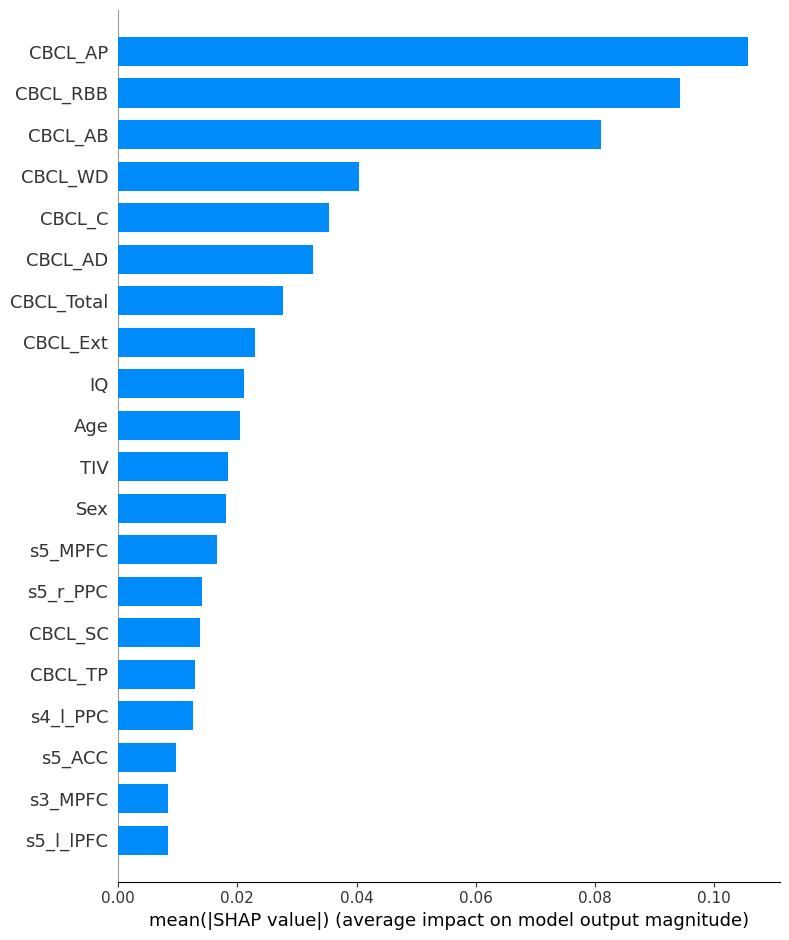

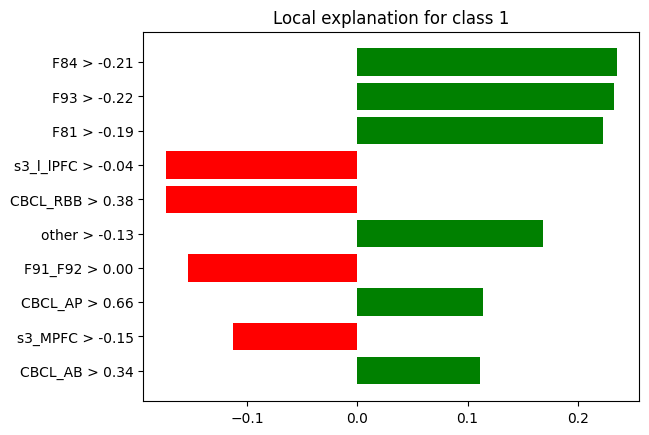

'<h4>Transformed training dataset</h4>'

mean difference = -0.000000
disparate impact = 1.000000


'<h4>Predictions</h4>'

Classification threshold used = 0.9306


 47%|████▋     | 47/100 [00:00<00:00, 463.49it/s]

Balanced accuracy = 0.6532
Statistical parity difference = 0.4872
Disparate impact = 1.9500
Average odds difference = 0.4964
Equal opportunity difference = 0.3171
Theil index = 0.2140
Mean Difference = 0.4872


100%|██████████| 100/100 [00:00<00:00, 500.80it/s]


PermutationExplainer explainer: 88it [00:53,  1.33it/s]                        


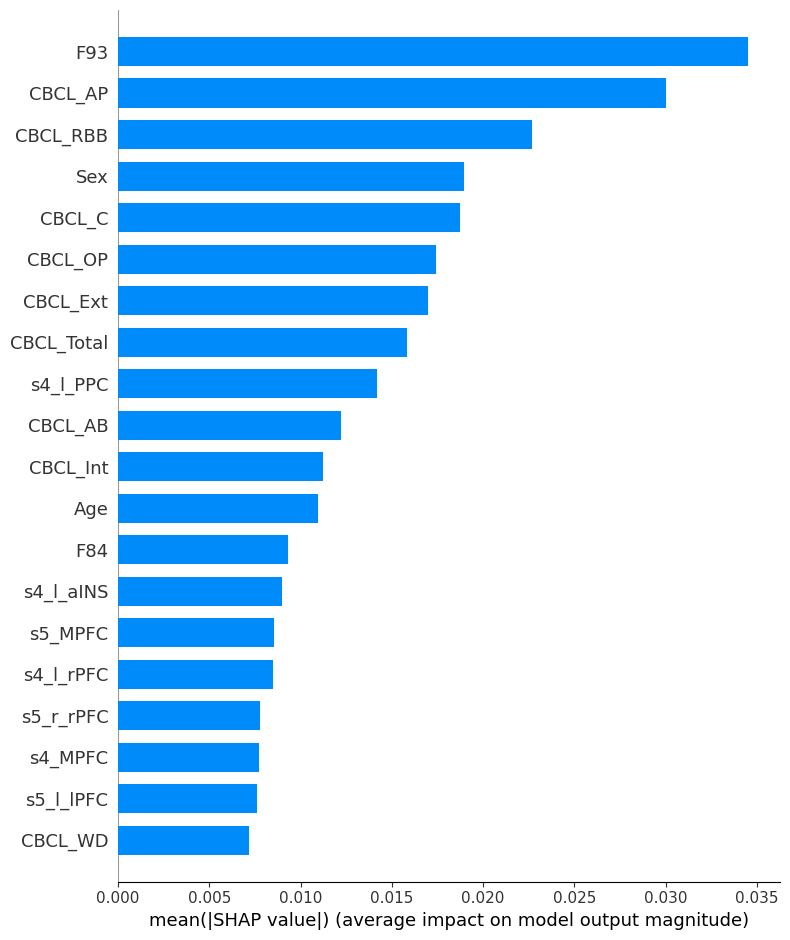

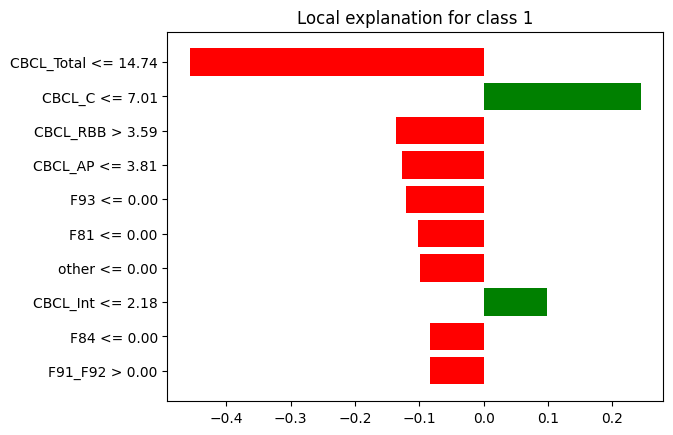

In [6]:


############### data load ###############
df, df_test = load_and_clean_data()
    
# create binary datasets
dataset_Binary, label_name, protected_attribute_names = create_binary_dataset(df)
dataset_orig_test, label_name, protected_attribute_names = create_binary_dataset(df_test)

# data split and peprocess
X_train, y_train, X_val, y_val, X_test, y_test, dataset_orig_train, dataset_orig_val, privileged_groups, unprivileged_groups = split_and_preprocess_model(dataset_Binary, dataset_orig_test)


########################## Select Algorithm ###############
#----------------------------------------------------------------------#
############### Adversarial Debiasing ###############

# adversarial_debiasing() 


############### Prejudice Remover ###############

# prejudice_remover()


############### Calibrated Equal Odds Post-Processing ###############

# cal_equal_odds('svm','weighted')         # define model ('svm', or 'xgb') and 
                                      # cost_constraint ('fnr', 'fpr' or 'weighted', false positive/negative rate)                 


############## reweighing ###############

reweighing('svm', 'svm')                    # define model and model_transf ('svm', or 'xgb')


############### Disparate Impact Remover ###############

# disparate_impact_remover('svm', 'svm')        # define model and model_transf ('svm', or 'xgb')